In [1]:
import os
import numpy as np
import pandas as pd
import glob
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt 
from matplotlib.pyplot import imshow
from PIL import Image
from bs4 import BeautifulSoup
from collections import Counter
from shutil import copyfile
import random
import pickle

% matplotlib inline

## Look at a few images

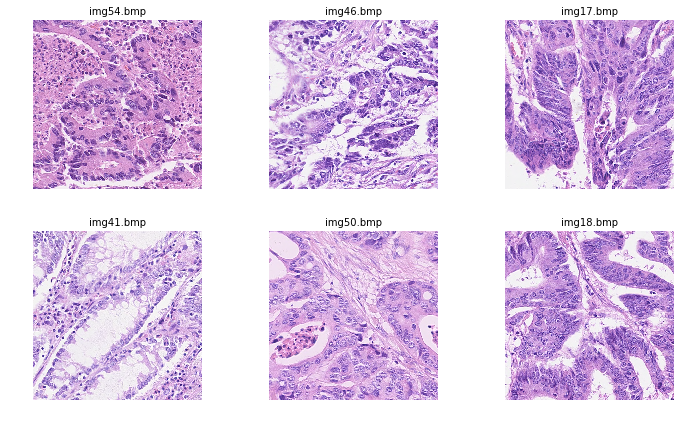

In [3]:
loc='/Users/rb/Documents/waterloo/projects/cancer_hist/CRCHistoPhenotypes_2016_04_28/Classification'
all_images=glob.glob(loc+'/**/*.bmp', recursive=True)
image_locs = np.random.choice(all_images, 6)

f = plt.figure(figsize=(10,6)) 
for i in range(len(image_locs)):
    sp = f.add_subplot(2, len(image_locs)//2, i+1)
    sp.axis('Off')
    sp.set_title(image_locs[i].rsplit('/', 1)[-1], fontsize=10)
    image = np.asarray(Image.open(image_locs[i]))
    plt.tight_layout()
    plt.imshow(image)

## Test Train Valid Split

In [4]:
def get_points_mat(labels_list):
    nuclei_type_list = ['epithelial', 'fibroblast', 'inflammatory', 'others', 'detection']
    points = {}
    
    for label_loc in labels_list:
        name = label_loc.rsplit('/', 1)[1].rsplit('_', 1)[0]
        nuclei_type = label_loc.rsplit('/', 1)[1].rsplit('_', 1)[1].rsplit('.', 1)[0]
        mat = scipy.io.loadmat(label_loc)
        points[nuclei_type] = np.round(mat['detection'])
    return points



def ttv_split(data_loc, out_dir, valid_proportion, test_proportion):
    all_images=glob.glob(data_loc+'/Classification/**/*.bmp', recursive=True)
    all_labels=glob.glob(data_loc+'/**/*.mat', recursive=True)
    num_images=len(all_images)
    num_labels=len(all_labels)
    print('num_images: ', num_images)
    print('num_labels: ', num_labels)

    # randomize the order for ttv split and divide into test train valid
    random.shuffle(all_images)
    ttv_files = {}
    ttv_files['train'] = all_images[0:int(np.ceil(num_images*(1-valid_proportion-test_proportion)))]
    ttv_files['test'] = all_images[int(np.ceil(num_images*(1-valid_proportion-test_proportion))) : int(np.ceil(num_images*(1-valid_proportion)))]
    ttv_files['valid'] = all_images[int(np.ceil(num_images*(1-valid_proportion))):]
    
    for ttv_dir, file_list in ttv_files.items():
        print(ttv_dir, len(file_list))
        for file in file_list:
            # Copy the image to the correct folder
            name = file.rsplit('/', 1)[1]
            new_loc = os.path.join(out_dir, ttv_dir, 'images')
            if not os.path.exists(new_loc):
                os.makedirs(new_loc)
            copyfile(file, os.path.join(new_loc , name))

            # also copy the labels
            labels_list = [loc for loc in all_labels if loc.rsplit('/', 1)[1].rsplit('_', 1)[0].rsplit('.', 1)[0] == name.rsplit('.', 1)[0]]
            name_label = name.rsplit('.', 1)[0]
            points = get_points_mat(labels_list)
            new_loc = os.path.join(out_dir, ttv_dir, 'labels')
            if not os.path.exists(new_loc):
                os.makedirs(new_loc)                
            with open(os.path.join(new_loc, name_label+'.pickle'), 'wb') as handle:
                pickle.dump(points, handle, protocol=pickle.HIGHEST_PROTOCOL)

    

data_loc = '/Users/rb/Documents/waterloo/projects/cancer_hist/CRCHistoPhenotypes_2016_04_28'
out_dir = '/Users/rb/Documents/waterloo/projects/cancer_hist/crc_ttv_split'

ttv_split(data_loc=data_loc, out_dir=out_dir, valid_proportion=.15, test_proportion=.25)

num_images:  100
num_labels:  499
train 60
test 25
valid 15


#### Tragically the 2-fold dataset code was deleted in a git related incident

## Create dataset for classifier

* Make the dataset consisting of all the detected points. 
* 4 Classes, plus the dected and not classified points.
* Add in non-nuclei points by taking some at least 5 pixels from the true center, because we still want points near the edge of the nuclei. We are training a classifier for the center. Double number of true points. 
* ? The detected but not classified will not hurt the classifier. We can do argmax excluding this. 
* Keras dir format

In [7]:
def extract_regions_crc(data_loc, out_dir, im_size, prop_neg=1):
    bad = ['img86']
    im_size=int(im_size)
    images_loc = os.path.join(data_loc, 'images')
    labels_loc = os.path.join(data_loc, 'labels')
    all_images=glob.glob(os.path.join(images_loc, '*'))
    all_labels=glob.glob(os.path.join(images_loc, '*'))

    num_images = len(all_images)
    print('num_images: ', num_images)
    
    for image_file in all_images:
        img_name = image_file.rsplit('/', 1)[1].rsplit('.', 1)[0]
        
        # load the points
        point_loc = os.path.join(labels_loc, img_name+".pickle")
        point_dict = pickle.load( open(point_loc, "rb" ))
        
        # load the image
        image = np.array(Image.open(image_file))
        im_name = image_file.rsplit('.', 1)[-2].rsplit('/', 1)[1]
        if im_name in bad:
            continue

        # pad the image so you can always take the proper sized image
        delta=int((im_size)/2)
        pad_width=int((im_size)/2)
        image = np.lib.pad(image, ((pad_width, pad_width), (pad_width, pad_width), (0,0)), 'constant', constant_values=(0, 0))

        ############### Get all of the nuclei
        num_pos = 0
        
        # detection nuclei includes all included in the labeled classes. Change this to only detected ones 
        # so not created twice
        try:
            all_nuclei = point_dict['detection'].tolist()
        except:
            all_nuclei = np.vstack([point_dict['epithelial'], point_dict['fibroblast'], 
                                       point_dict['inflammatory'], point_dict['others']]).tolist()

        all_labeled_nuclei = np.vstack([point_dict['epithelial'], point_dict['fibroblast'], 
                                       point_dict['inflammatory'], point_dict['others']]).tolist()
        
        only_detection_nuclei = [row for row in all_nuclei if row not in all_labeled_nuclei]
        point_dict['detection'] = only_detection_nuclei

        for nuclei_type, point_list in point_dict.items():
            new_loc = os.path.join(out_dir, nuclei_type)
            if not os.path.exists(new_loc):
                os.makedirs(new_loc)
            for point in point_list:
                x=int(point[0]) + delta
                y=int(point[1]) + delta

                seg_image = image[y-delta:y+delta, x-delta:x+delta,:]
                out_name=str(nuclei_type)+'_'+str(num_pos)+'_'+im_name+'.jpg'

                outfile=os.path.join(new_loc, out_name)
                scipy.misc.imsave(outfile, seg_image)
                num_pos = num_pos+1
            
        # Get Negatives. Evenly sample from every image:
        samples_needed = np.round(float(30000)/100)*prop_neg
        samp_taken = 0
        new_loc = os.path.join(out_dir, 'negative')
        if not os.path.exists(new_loc):
            os.makedirs(new_loc)
        while (samp_taken < samples_needed):
            row = random.randint(pad_width, image.shape[0]-pad_width)
            col = random.randint(pad_width, image.shape[1]-pad_width)
            proposed_center = np.array([row, col])
            dists = np.sqrt(np.sum((all_nuclei - proposed_center) ** 2, axis=1))
            min_ind = np.argmin(dists)
            if (dists[min_ind] > 6):
                seg_image = image[row-delta:row+delta, col-delta:col+delta,:]
                out_name=str(0)+'_'+str(samp_taken)+'_'+im_name+'.jpg'
                outfile=os.path.join(new_loc, out_name)
                scipy.misc.imsave(outfile, seg_image)
                samp_taken=samp_taken+1

                
def extract_crc_only_class(data_loc, out_dir, im_size):
    # ignore all non-labeled and non-nuclei.
    # this is only for classification, not localization
    bad = ['img86']
    im_size=int(im_size)
    images_loc = os.path.join(data_loc, 'images')
    labels_loc = os.path.join(data_loc, 'labels')
    all_images=glob.glob(os.path.join(images_loc, '*'))
    all_labels=glob.glob(os.path.join(images_loc, '*'))

    num_images = len(all_images)
    print('num_images: ', num_images)
    
    for image_file in all_images:
        img_name = image_file.rsplit('/', 1)[1].rsplit('.', 1)[0]
        
        # load the points
        point_loc = os.path.join(labels_loc, img_name+".pickle")
        point_dict = pickle.load(open(point_loc, "rb" ))
        
        # load the image
        image = np.array(Image.open(image_file))
        im_name = image_file.rsplit('.', 1)[-2].rsplit('/', 1)[1]
        if im_name in bad:
            continue

        # pad the image so you can always take the proper sized image
        delta=int((im_size)/2)
        pad_width=int((im_size)/2)
        image = np.lib.pad(image, ((pad_width, pad_width), (pad_width, pad_width), (0,0)), 'constant', constant_values=(0, 0))

        ############### Get all of the nuclei
        try:
            del point_dict['detection'] 
        except:
            pass
        num_pos=0

        for nuclei_type, point_list in point_dict.items():
            new_loc = os.path.join(out_dir, nuclei_type)
            if not os.path.exists(new_loc):
                os.makedirs(new_loc)
            for point in point_list:
                x=int(point[0]) + delta
                y=int(point[1]) + delta

                seg_image = image[y-delta:y+delta, x-delta:x+delta,:]
                out_name=str(nuclei_type)+'_'+str(num_pos)+'_'+im_name+'.jpg'

                outfile=os.path.join(new_loc, out_name)
                scipy.misc.imsave(outfile, seg_image)
                num_pos = num_pos+1

In [5]:
# im_size = 64

# data_loc = '/Users/rb/Documents/waterloo/projects/cancer_hist/crc_ttv_split/valid'
# out_dir = '/Users/rb/Documents/waterloo/projects/cancer_hist/crc_64/valid'
# extract_regions_crc(data_loc=data_loc, out_dir=out_dir, im_size=im_size, prop_neg=1)

# data_loc = '/Users/rb/Documents/waterloo/projects/cancer_hist/crc_ttv_split/train'
# out_dir = '/Users/rb/Documents/waterloo/projects/cancer_hist/crc_64/train'
# extract_regions_crc(data_loc=data_loc, out_dir=out_dir, im_size=im_size, prop_neg=1)

# data_loc = '/Users/rb/Documents/waterloo/projects/cancer_hist/crc_ttv_split/test'
# out_dir = '/Users/rb/Documents/waterloo/projects/cancer_hist/crc_64/test'
# extract_regions_crc(data_loc=data_loc, out_dir=out_dir, im_size=im_size, prop_neg=1)

In [8]:
# Classification data
# fold 1
im_size = 128
data_loc = '/Users/rb/Documents/waterloo/projects/cancer_hist/crc_ttv_split_f1/valid'
out_dir = '/Users/rb/Documents/waterloo/projects/cancer_hist/crc_2_fold_128/crc_128_fold_1/valid'
extract_crc_only_class(data_loc=data_loc, out_dir=out_dir, im_size=im_size)

data_loc = '/Users/rb/Documents/waterloo/projects/cancer_hist/crc_ttv_split_f1/train'
out_dir = '/Users/rb/Documents/waterloo/projects/cancer_hist/crc_2_fold_128/crc_128_fold_1/train'
extract_crc_only_class(data_loc=data_loc, out_dir=out_dir, im_size=im_size)

data_loc = '/Users/rb/Documents/waterloo/projects/cancer_hist/crc_ttv_split_f1/test'
out_dir = '/Users/rb/Documents/waterloo/projects/cancer_hist/crc_2_fold_128/crc_128_fold_1/test'
extract_crc_only_class(data_loc=data_loc, out_dir=out_dir, im_size=im_size)

# fold 2
data_loc = '/Users/rb/Documents/waterloo/projects/cancer_hist/crc_ttv_split_f2/valid'
out_dir = '/Users/rb/Documents/waterloo/projects/cancer_hist/crc_2_fold_128/crc_128_fold_2/valid'
extract_crc_only_class(data_loc=data_loc, out_dir=out_dir, im_size=im_size)

data_loc = '/Users/rb/Documents/waterloo/projects/cancer_hist/crc_ttv_split_f2/train'
out_dir = '/Users/rb/Documents/waterloo/projects/cancer_hist/crc_2_fold_128/crc_128_fold_2/train'
extract_crc_only_class(data_loc=data_loc, out_dir=out_dir, im_size=im_size)

data_loc = '/Users/rb/Documents/waterloo/projects/cancer_hist/crc_ttv_split_f2/test'
out_dir = '/Users/rb/Documents/waterloo/projects/cancer_hist/crc_2_fold_128/crc_128_fold_2/test'
extract_crc_only_class(data_loc=data_loc, out_dir=out_dir, im_size=im_size)

num_images:  10
num_images:  40
num_images:  50
num_images:  10
num_images:  40
num_images:  50


## Look at some annotated images

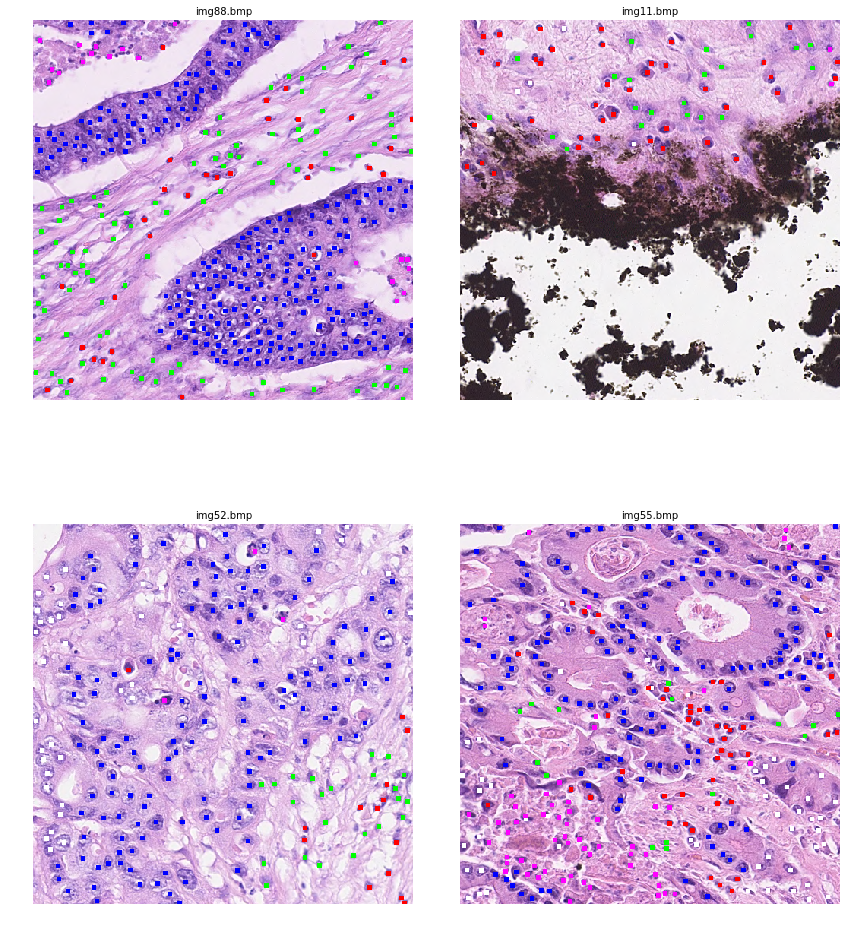

In [11]:
import sys
sys.path.insert(0, '/Users/rb/Google_Drive/Waterloo/projects/cancer_hist/src')

data_loc ='/home/rbbidart/project/rbbidart/cancer_hist/crc_ttv_split/train/images/'
all_images=glob.glob(data_loc+'/**/*.bmp', recursive=True)
image_locs = np.random.choice(all_images, 4)

f = plt.figure(figsize=(12,15))

for i in range(0, len(image_locs)):
    image_loc = image_locs[i]
    label_loc = image_loc.replace('images', 'labels')
    label_loc = label_loc.replace('.bmp', '.pickle')
    point_dict = pickle.load( open(label_loc, "rb" ))

    # Delete detected points that are in any other set:
    try:
        all_nuclei = point_dict['detection'].tolist()
    except:
        all_nuclei = np.vstack([point_dict['epithelial'], point_dict['fibroblast'], 
                                   point_dict['inflammatory'], point_dict['others']]).tolist()
    all_labeled_nuclei = np.vstack([point_dict['epithelial'], point_dict['fibroblast'], 
                                   point_dict['inflammatory'], point_dict['others']]).tolist()
    only_detection_nuclei = [row for row in all_nuclei if row not in all_labeled_nuclei]
    point_dict['detection'] = only_detection_nuclei

    image = Image.open(image_loc)
    image2 = np.asarray(image).astype(int)
    
    for nuclei_type, point_list in point_dict.items():
        if nuclei_type == 'epithelial':
            color = [0, 0, 255]
        elif nuclei_type == 'fibroblast':
            color = [0, 255, 0]  
        elif nuclei_type == 'inflammatory':
            color = [255, 0, 0]
        elif nuclei_type == 'others':
            color = [255, 0, 255]
        elif nuclei_type == 'detection':
            color = [255, 255, 255]
        for point in point_list:
            image2[int(point[1])-3:int(point[1])+3, int(point[0])-3:int(point[0])+3, :] = color  

    sp = f.add_subplot(2, len(image_locs)//2, i+1)
    sp.axis('Off')
    sp.set_title(image_loc.rsplit('/', 1)[-1], fontsize=10)
    plt.tight_layout()
    plt.imshow(image2.astype(np.uint8))